# microsim guide

This guide walks through some of the basic concepts of microsim, with examples

## Creating a sample

The simulation begins with some sort of sample or "ground truth".  This is
essentially a spatial distribution of signal-emitting objects.  `microsim`
provides a few built-in sample distributions, but you can also create your own.

The distribution is represented as a count of fluorophores in a 3-dimensional
space.  That space is referred to as the *truth space*.  So, a very basic sample
example, drawing some randomly oriented lines into a 64x256x256 space, with a
ground truth voxel size of 10nm x 10nm x 10nm, might look like this:

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


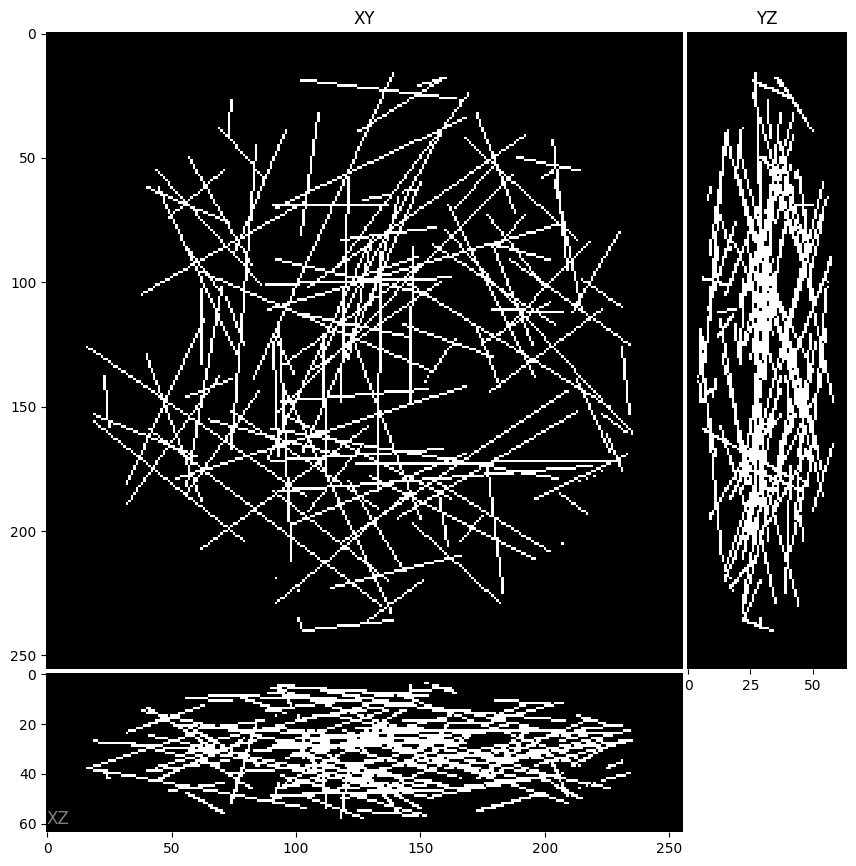

In [35]:
from microsim import schema as ms
from microsim.util import ortho_plot

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(64, 256, 256), scale=0.01),
    sample=[ms.MatsLines()],
)

ortho_plot(sim.ground_truth(), mip=True)

## Biologically realistic ground truth from Janelia CellMap

We can also create more biologically realistic ground truth.  For example,
microsim provides a wrapper around the Janelia
[OpenOrganelle](https://www.openorganelle.org) dataset, which is a rich dataset
of FIB-SEM images of cells, together with annotations of various organelles.
Let's simulate endoplasmic reticulum (ER) and mitochondria (mito):

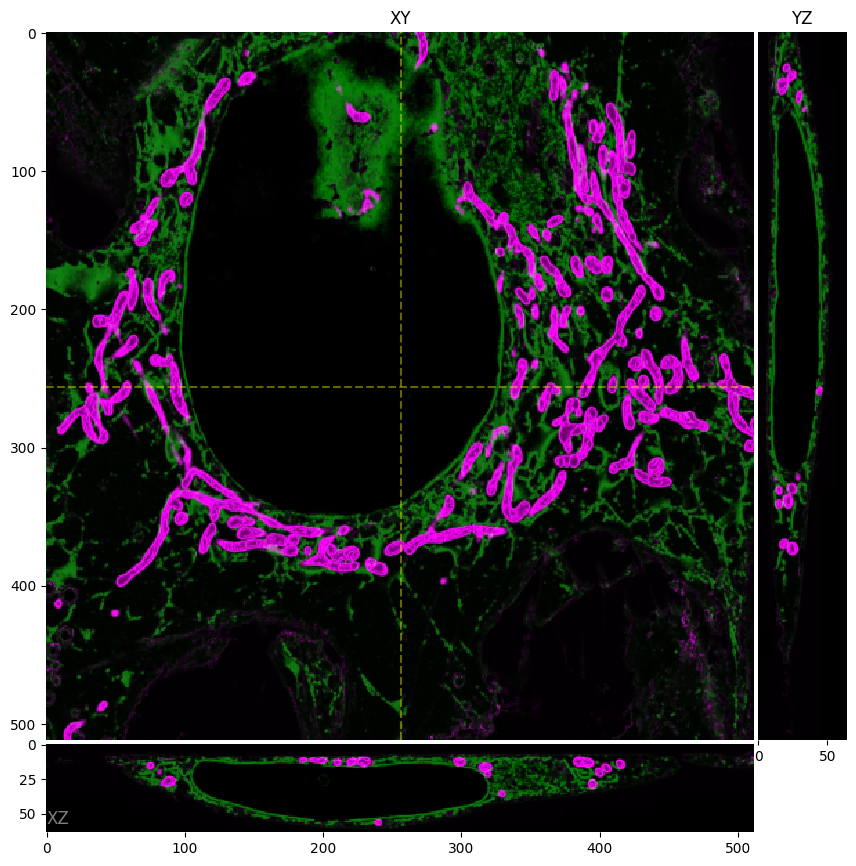

In [36]:
from microsim import schema as ms

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(
        shape=(64, 512, 512),
        scale=(0.064, 0.064, 0.064),
    ),
    # dataset & label names from https://openorganelle.janelia.org/datasets
    sample=[
        ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
        ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
    ],
)

ortho_plot(sim.ground_truth())

(or, plotted as maximum intensity projection):

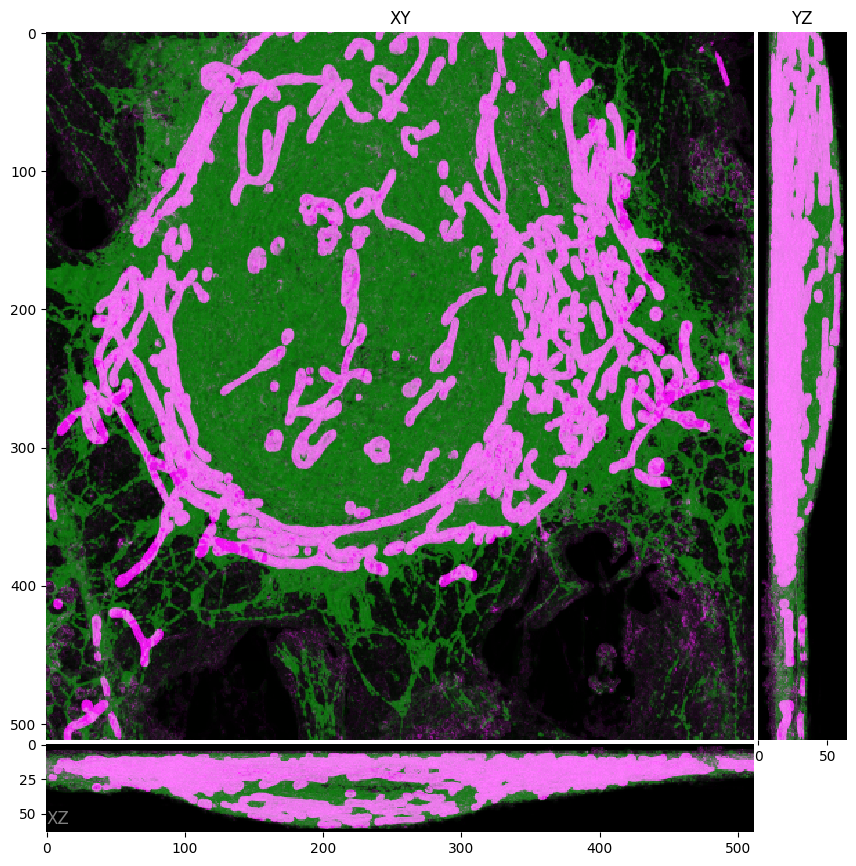

In [37]:
ortho_plot(sim.ground_truth(), mip=True)

### Optical Image

Without any additional config, we can simulate an image as viewed
with a widefield microscope:

INFO:root:Rendering channel FITC -----------------
INFO:root:>> fluor mockFluorophore
INFO:root:>>>> @ 525.2525940250172 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_57_0-064_0-064_0-5252525940250172.npy
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 58, 58) a.dtype=dtype('float64')
INFO:root:>> fluor mockFluorophore
INFO:root:>>>> @ 525.2525940250172 nm
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 58, 58) a.dtype=dtype('float64')


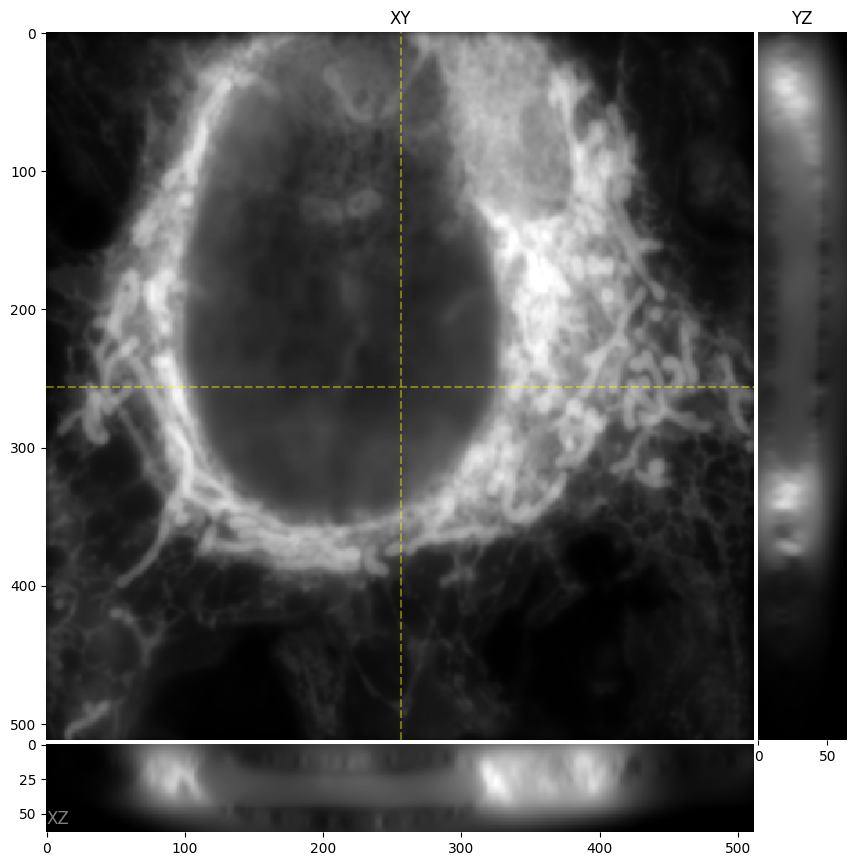

In [38]:
ortho_plot(sim.optical_image())

OK ... looks more or less like a widefield image of a cell.
But there's something wrong: the organelles are superimposed in the same channel!  That makes sense, since we haven't added any information about the fluorophores and filters.  Let's add the concept of fluorophores and optical configurations.

## Fluorophores, Spectra, and Optical Configurations

Here we'll turn the three `CosemLabel` objects into `FluorophoreDistribution`
objects, each with a specified `fluorophore` (the information for each fluorophore is
pulled from [FPbase](https://fpbase.org).  We'll also specify the `channels`
in the simulation, which is a list of `OpticalConfiguration` objects.  These objects
describe the optical configuration of the microscope, including the excitation and
emission spectra of the light sources and detectors (The
`microsim.schema.optical_config.lib` module provides a library of common optical
configurations)

In [39]:
from microsim import schema as ms

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(
        shape=(64, 512, 512),
        scale=(0.064, 0.064, 0.064),
    ),
    # dataset & label names from https://openorganelle.janelia.org/datasets
    sample=[
        ms.FluorophoreDistribution(
            distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
            fluorophore="EGFP",
        ),
        ms.FluorophoreDistribution(
            distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
            fluorophore="mCherry",
        ),
    ],
    channels=[
        ms.OpticalConfig.from_fpbase(
            microscope_id="wKqWbg", config_name="Widefield Green"
        ),
        ms.OpticalConfig.from_fpbase(
            microscope_id="wKqWbg", config_name="Widefield Red"
        ),
    ],
)

Let's first discuss how the fluorophores are excited and collected by our optical
configurations. The number of photons emitted by a fluorophore and collected by a
detector in any given channel is determined by multiple things, including:

1. How well the absorption spectrum of the fluorophore overlaps with the excitation
   spectrum of the light source
2. How well the emission spectrum of the fluorophore overlaps with the spectra of
   the filters in the emission path and the detector.

### Fluorophore Absorption Spectrum

We can visualize the absorption spectra of the fluorophores in our
sample, which represents how well each of the fluorophores absorbs light at a specific wavelength:

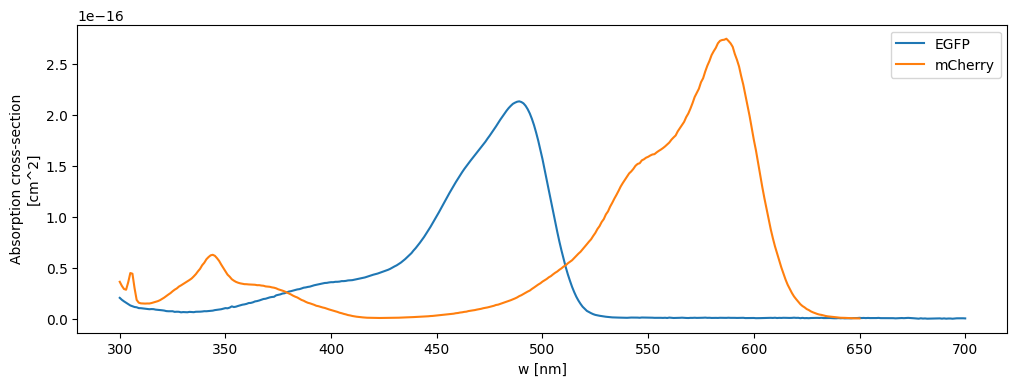

In [40]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))
for lbl in sim.sample.labels:
    fluor = lbl.fluorophore
    fluor.absorption_cross_section.plot.line(label=fluor.name)

plt.legend()
plt.show()

<div class="admonition info"><p class="admonition-title">Absorption cross section</p><p>

The excitation spectra have been scaled here by the extinction coefficient of the
fluorophore and converted to
[absorption cross-section](https://en.wikipedia.org/wiki/Absorption_cross_section)
($\sigma$) using the formula:

$$
  \sigma(\lambda) = \log(10) \times 10^3 \times \frac{E(\lambda)}{N_A}
$$

Where $E(\lambda)$ is the extinction coefficient in $M^{-1} cm^{-1}$, and $N_A$ is Avogadro's number.
</p></div>

### Excitation Path Illumination Flux

The filters and light sources in each of the optical configurations determines its excitation profile and power.  Here, we plot the individual excitation profiles of each of the filters in each channel, as well as the total combined **illumination flux** density ($photons / cm^2 / sec$) for each channel:

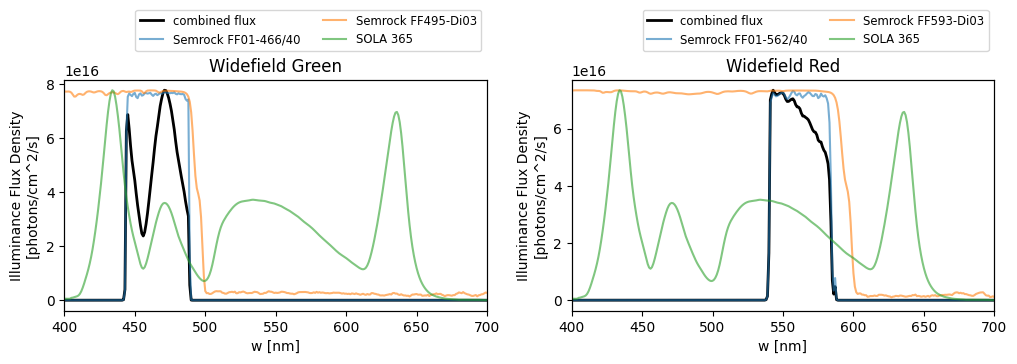

In [41]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    oc.plot_excitation(ax=axes[_ch_idx])

<div class="admonition info"><p class="admonition-title">Illumination flux</p><p>

The illumination flux density ($\phi_{\text{flux}}$) for a given channel is a measure of the photons per unit area per second delivered to the specimen:

$$
  \phi_{\text{flux}}(\lambda) = \frac{P_{\text{exc}}(\lambda) \cdot \lambda}{hc}
$$

where:
- $P_{\text{exc}}(\lambda)$ is the irradiance of the excitation light source at wavelength $\lambda$ (in units of $W/cm^2$)
- $h$ is Planck's constant
- $c$ is the speed of light, and $\lambda$ is the wavelength of the light source in meters.

</p></div>

### Fluorophore Absorption Rate

The product of the absorption cross section and the excitation spectrum gives us the wavelength-dependent **absorption rate** 
(in $photons/sec$) for each channel-fluorophore pair.

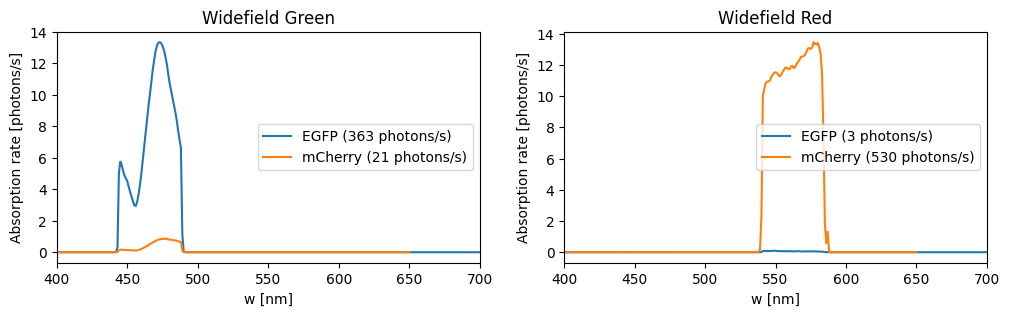

In [42]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    for lbl in sim.sample.labels:
        fluor = lbl.fluorophore
        abs_rate = oc.absorption_rate(fluor)
        label = f'{fluor.name} ({abs_rate.sum():.0f} photons/s)'
        abs_rate.plot(ax=axes[_ch_idx], label=label)
    axes[_ch_idx].set_xlim(400, 700)
    axes[_ch_idx].legend(loc='center right')
    axes[_ch_idx].set_title(oc.name)

<div class="admonition info"><p class="admonition-title">Absorption rate</p><p>

Absorption rate ($\phi_{\text{abs}}$) is calculated as:

$$
  \phi_{\text{abs}}(\lambda) = \sigma(\lambda) \times \phi_{\text{flux}}(\lambda)
$$

where:
- $\sigma(\lambda)$ is the absorption cross section of the fluorophore at wavelength $\lambda$
- $\phi_{\text{flux}}(\lambda)$ is the illumination flux density ($photons/cm^2/sec)$ at wavelength $\lambda$, described above.

</p></div>

### Fluorophore Emission Rate

We convert absorption rate to emission rate by normalizing the area under the emission
spectrum of the fluorophore to the total number of photons absorbed by the fluorophore,
multiplied by the **quantum yield** of the fluorophore.  This gives us the number of photons
emitted by each fluorophore, when illuminated by each channel, at each wavelength:

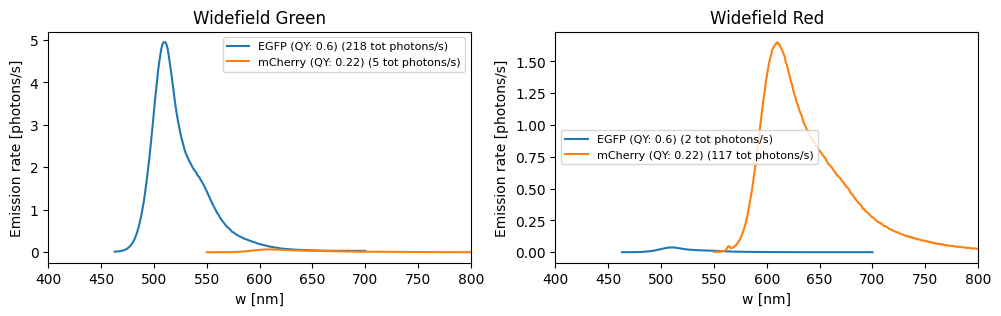

In [43]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    for lbl in sim.sample.labels:
        fluor = lbl.fluorophore
        em_rate = oc.total_emission_rate(fluor)
        label = (
            f"{fluor.name} (QY: {fluor.quantum_yield}) "
            f"({em_rate.sum():.0f} tot photons/s)"
        )
        em_rate.plot(ax=axes[_ch_idx], label=label)
    axes[_ch_idx].set_xlim(400, 800)
    axes[_ch_idx].legend(fontsize=8)
    axes[_ch_idx].set_title(oc.name)


As expected, EGFP is emitting more photons when imaged in the "Widefield Green"
channel, and mCherry is emitting more photons when imaged in the "Widefield Red" channel.

<div class="admonition info"><p class="admonition-title">Emission rate</p><p>

The total emission rate ($\phi_{\text{em}}$) of a given fluorophore in a given channel is calculated as:

$$
  \phi_{\text{em}}(\lambda) = \frac{I_{\text{em}}(\lambda)}{\int I_{\text{em}}(\lambda) d\lambda} \times QY \times \phi_{\text{abs}}(\lambda)
$$

where:
- $I_{\text{em}}(\lambda)$ is the emission spectrum of the fluorophore at wavelength $\lambda$ (normalized such that the total area under the curve is 1)
- $QY$ is the quantum yield of the fluorophore
- $\phi_{\text{abs}}(\lambda)$ is the absorption rate of the fluorophore at wavelength $\lambda$, described above.

</p></div>


### Emission Path Collection Efficiency

The photons then travel through the emission filters and hit the detector, which itself
has some wavelength-specific quantum efficiency (not shown here). The combined transmission percentage of
all of the filters in the emission path, and the QE of the detector if specified, gives
us the **combined collection efficiency**:

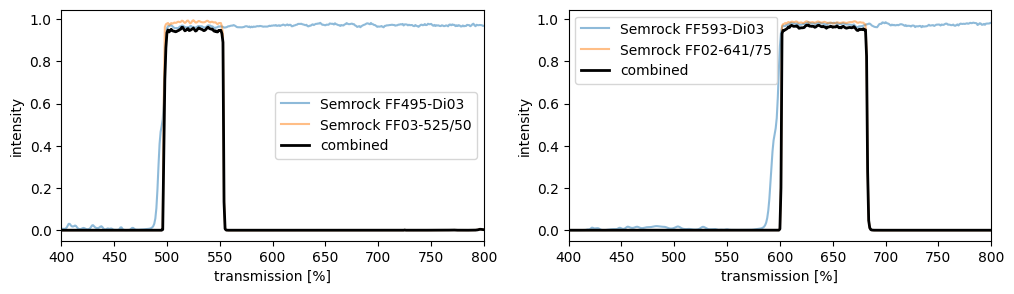

In [44]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    oc.plot_emission(ax=axes[_ch_idx])

### Collection Rate

The product of the emission rate and the combined collection efficiency gives us the
**collection rate**: number of photons/sec detected for each fluorophore, in each
channel:

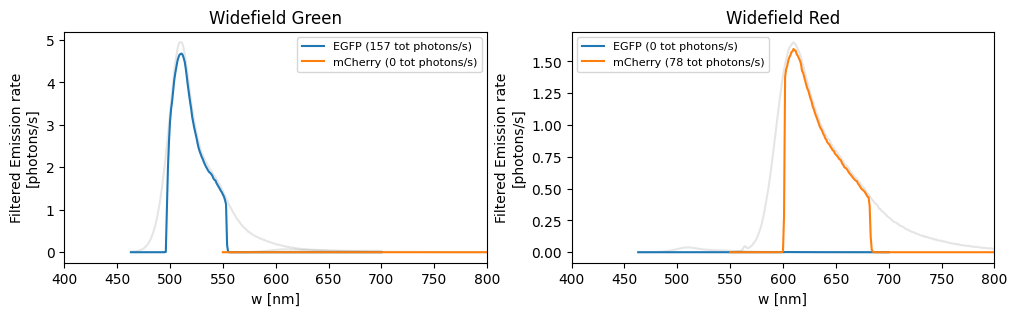

In [45]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    for lbl in sim.sample.labels:
        fluor = lbl.fluorophore
        oc.total_emission_rate(fluor).plot(ax=axes[_ch_idx], color="k", alpha=0.1)
        filtered_rate = oc.filtered_emission_rate(fluor)
        label = f"{fluor.name} ({filtered_rate.sum():.0f} tot photons/s)"
        filtered_rate.plot(ax=axes[_ch_idx], label=label)
    axes[_ch_idx].set_xlim(400, 800)
    axes[_ch_idx].legend(fontsize=8)
    axes[_ch_idx].set_title(oc.name)

<div class="admonition warning"><p class="admonition-title">Don't forget the optics</p><p>

Note that this is not the end of the story!

The math so far assumes we collect photons emitted in every direction.  In reality, the number of photons detected is additionally affected by numerical aperture of the detector, transmission efficiency of the optics, and other factors.  We may deal with those later.
</p></div>

### Optical Image, Revisited

Now that we've added fluorophores and optical configurations, let's simulate the optical image again:

INFO:root:Rendering channel Widefield Green -----------------
INFO:root:>> fluor EGFP
INFO:root:>>>> @ 520.0266456901008 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_57_0-064_0-064_0-5200266456901008.npy
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 58, 58) a.dtype=dtype('float64')
INFO:root:>> fluor mCherry
INFO:root:>>>> @ 590.7878206897133 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_65_0-064_0-064_0-5907878206897133.npy
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 66, 66) a.dtype=dtype('float64')
INFO:root:Rendering channel Widefield Red -----------------
INFO:root:>> fluor EGFP
INFO:root:>>>> @ 629.547261040316 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_69_0-064_0-064_0-6295472610

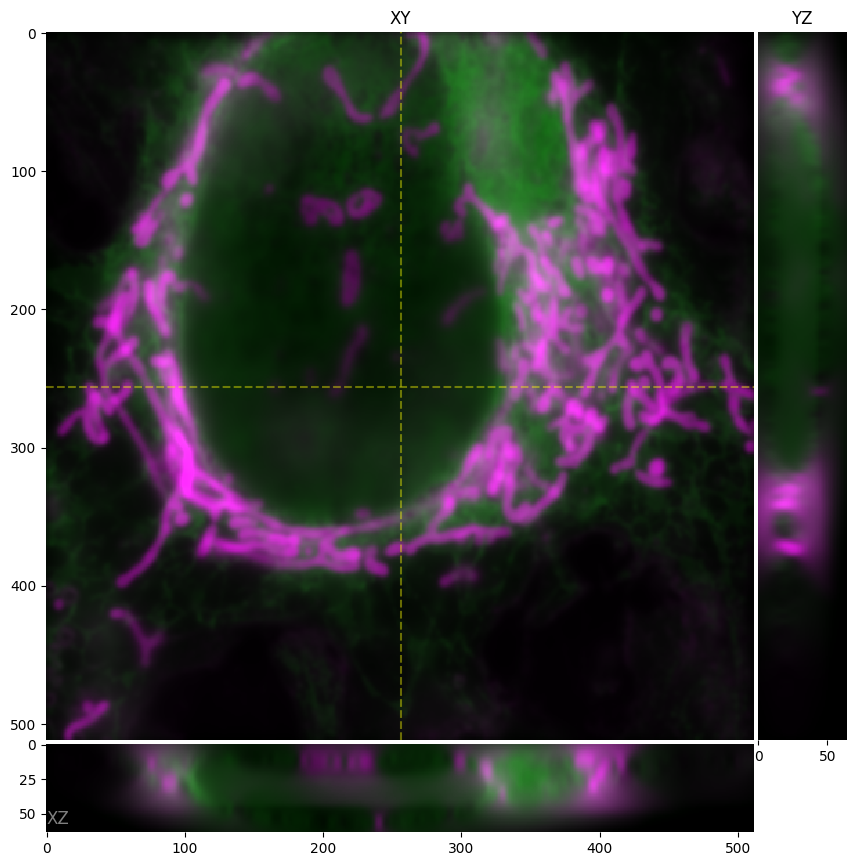

In [46]:
ortho_plot(sim.optical_image())

## Detectors, Pixelation, and Noise

The final step in the simulation is to convert the optical rates into a digital image.  Let's add a detector.

INFO:root:Rendering channel Widefield Green -----------------
INFO:root:>> fluor EGFP
INFO:root:>>>> @ 519.3324878523201 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_57_0-064_0-064_0-5193324878523201.npy
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 58, 58) a.dtype=dtype('float64')
INFO:root:>> fluor mCherry
INFO:root:>>>> @ 555.856558265987 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_61_0-064_0-064_0-555856558265987.npy
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 62, 62) a.dtype=dtype('float64')
INFO:root:Rendering channel Widefield Red -----------------
INFO:root:>> fluor EGFP
INFO:root:>>>> @ 626.9971716823247 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_69_0-064_0-064_0-62699717168

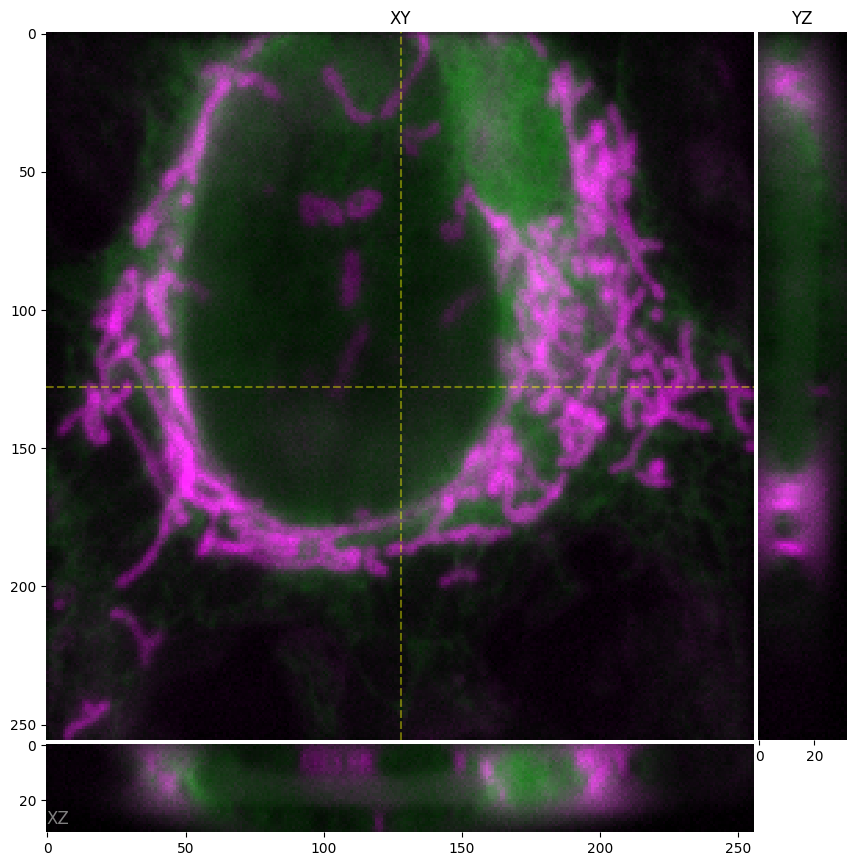

In [47]:
# mutating the simulation in-place
sim.detector = ms.detectors.ICX285
sim.output_space = ms.DownscaledSpace(downscale=2)

ortho_plot(sim.digital_image())